In [73]:
%matplotlib inline

import pandas as pd
import numpy as np
from utility_functions import report

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

 _______________________________________________
# Multi genre Classification
## # echonest audio features
 _______________________________________________

# 1. Preprocessing

In [ ]:
echo_genres = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/Data/Dataset [cleaned]/echo_audiofeatures_genres.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()

In [75]:
echo_genres.genre_top.value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: genre_top, dtype: int64

In [76]:
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop',
          'Classical','Jazz']
# generating dataset for multiclass classification task
echo_gen = echo_genres[echo_genres['genre_top'].isin(genres_subset)]
echo_gen.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


In [77]:
echo_gen.shape

(9055, 9)

In [78]:
pd.concat([echo_gen.genre_top.value_counts(),
                round(echo_gen.genre_top.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,3892,42.98
Electronic,2170,23.96
Hip-Hop,910,10.05
Folk,874,9.65
Old-Time / Historic,357,3.94
Pop,346,3.82
Classical,265,2.93
Jazz,241,2.66


In [ ]:
# encoding labels
le = preprocessing.LabelEncoder()
echo_gen['genre_top'] = le.fit_transform(echo_gen['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')
echo_gen.genre_top.value_counts()

In [ ]:
# detach target col
labels = echo_gen[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [ ]:
echo_gen.drop('genre_top', axis=1, inplace=True)

In [ ]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(echo_gen)

# 2. PCA on normalized data (scaled_features)
## 2.1 Determine optimal number of components
### a) scree-plot

In [ ]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### b) cumulative explained variance plot

In [ ]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)


## 2.2 Plot PCA in 2D

In [ ]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['genres'] = le.inverse_transform(labels)

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

Rock, Classic and Hip-Hop are well separated from the others.
Jazz instead, is very close to classical (probably due to instrumentality of the two genres), in fact
is located on the leftmost side of the graph.

### 2.3 Plot PCA in 3D

In [1]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='genres',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
),width=700, height=700, scene_camera_eye_z=0.8)
fig.show()

NameError: name 'px' is not defined

# 3. Split data for classification

In [ ]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=10)

# (no PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=10)

In [ ]:
# check partitions
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n***PCA***\nDevelopment set:\n{y_develop_pca.value_counts()}\n\nInternal Test:\
\n{y_test_pca.value_counts()}\n\n\-----------------\n\***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

# 4. Decision Tree
### a) Unbalanced - without PCA
#### - Validation Schema: coarse grid-search with 5 fold CV
We adopt a 5 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [34]:
# search parameters
param_grid = {
               "max_depth": [3,4,5,6,7,8,9,10, None],
               "min_samples_leaf": [25,20,35,40,45,50,55,75],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.624 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.624 (std: 0.016)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 25}

Model with rank: 3
Mean validation score: 0.623 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 45}

Model with rank: 4
Mean validation score: 0.622 (std: 0.012)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 25}

Model with rank: 5
Mean validation score: 0.621 (std: 0.015)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 45}

Model with rank: 5
Mean validation score: 0.621 (std: 0.015)
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 45}

Model with rank: 7
Mean validation score: 0.621 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth

#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc

The roc curve will be saved as:
- roc_auc0

The false and true positive rates will be saved as:
- fpr0
- tpr0

In [ ]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 25)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 51   0  18   0   0   8   0   4]
 [  3 360  12  35   0   2   3 220]
 [ 12  22 101   9   0   5   3 131]
 [  0  79   2 132   0   1   0  52]
 [  6   4  10   6   0   0   0  40]
 [ 10   1   9   3   0  83   1   6]
 [  2  23  14   7   0   1   3  61]
 [  6 126  44  32   0   6  10 938]]


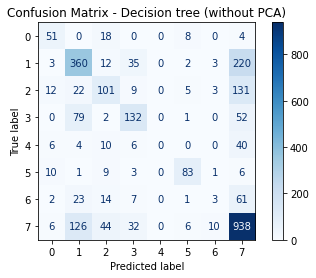

In [49]:
# confusion matrix - Internal Test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA
#### Validation schema:  repeated 5 fold cross validation - grid search

In [50]:
# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.586 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.586 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 35}

Model with rank: 3
Mean validation score: 0.585 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 35}

Model with rank: 4
Mean validation score: 0.584 (std: 0.012)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 35}

Model with rank: 5
Mean validation score: 0.584 (std: 0.019)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 25}

Model with rank: 6
Mean validation score: 0.584 (std: 0.019)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 25}

Model with rank: 7
Mean validation score: 0.583 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_

#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [ ]:
dtc_pca = DecisionTreeClassifier(criterion= 'entropy',max_depth=5, min_samples_leaf= 40)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))


Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 37   0  25   0   0  15   0   4]
 [  5 317  26  34   0  10   0 243]
 [ 19  10  97  12   0  21   0 124]
 [  0  63   3 140   0   9   0  51]
 [  6   3  22   3   0   3   0  29]
 [  6   2  25   2   0  69   0   9]
 [  2  10  12  11   0   2   0  74]
 [  9 101  60  38   0  24   0 930]]


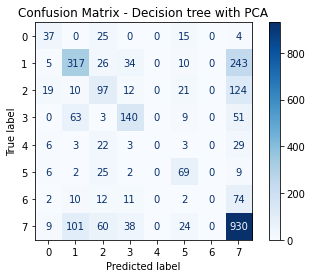

In [52]:
# confusion matrix Decision tree with PCA
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

# 5. KNN
### a) Unbalanced - without PCA
#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [60]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
#report(clf.cv_results_)

100%|██████████| 39/39 [00:26<00:00,  1.47it/s]


[0.5455980484498733, 0.5121468546453969, 0.5799948669646817, 0.5968778188088368, 0.6014509545950633, 0.6113856205241676, 0.6175430203178494, 0.6247982916461096, 0.6266927803609074, 0.6292201773139773, 0.6307957201449211, 0.6304807610846154, 0.6311091841463962, 0.6360012658164765, 0.6337928147472603, 0.6348971648701043, 0.6331621490972337, 0.6317418432081969, 0.6314276316773065, 0.6333218712156323, 0.6323754989758846, 0.6339522876891872, 0.6348989091054066, 0.634901650046596, 0.6334798490987288, 0.6345841992215726, 0.633797299923752, 0.6344289622796657, 0.6372683281753804, 0.6358482714628153, 0.6353735902841111, 0.6339550286303766, 0.6339540319244895, 0.6330081580376854, 0.6328489342722303, 0.6296948584926816, 0.6293791519029608, 0.6298520888463628, 0.6304830036728613]
maximum score: 0.6372683281753804 for k = 29


#### Train and predict

In [ ]:
knn =  KNeighborsClassifier(n_neighbors = 11)
# retrain knn on the whole development set
knn.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test)

# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Hip-Hop\n1: Rock')

#### Confusion matrix

In [ ]:
# confusion matrix KNN - Internal test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_knn = plot_confusion_matrix(knn,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [ ]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
#report(clf.cv_results_)

## 3.1.2 Prediction on Internal test set (KNN - with PCA)
#### Train and predict

In [ ]:
knn_pca =  KNeighborsClassifier(n_neighbors = 22)
# retrain knn on the whole development set
knn_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))

#### Confusion matrix

In [ ]:
cm_knn_pca = plot_confusion_matrix(knn_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()